# Phase 2: Weighted method test


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import math
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_data(formation_date, data_universe, equity_data, bond_data, fama_data, TMT):
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = 12)
    
    bond_data_ = bond_data[(bond_data.DATE >= form_date) & (bond_data.DATE <= limitf_date) & (bond_data.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 12)
    #limitavg_date =  form_date + relativedelta.relativedelta(months = 12)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date > avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == 12].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    #fama
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
        
    bond_data___ = pd.merge(bond_data__, fama_data[['dateem', 'rf']], how='left', left_on = ['DATE'], right_on=['dateem'])
    bond_data___.YIELD = bond_data___.YIELD.str.replace('%', '').astype('float').divide(100.0)
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    
    equity_data___ = pd.merge(equity_data__, fama_data[['dateff', 'rf']], how='left', left_on = ['date'], right_on=['dateff'])

    return(equity_data___, bond_data___)

In [4]:
def rank_port_decile(equity_data , formation_date, num_month, strat_type = 0):
    
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    avg_date =  form_date - relativedelta.relativedelta(months = num_month)
    check_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, check_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date >= avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
    except:
        print('There is no C')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    #residual
    if strat_type != 0:
        equity_data_.RETX = equity_data_.RETX - equity_data_.rf
    
    #equity_data_.RETX = equity_data_.RETX.add(1) #cumulative
    
    equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'mean'})
    #equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'prod'}) #cumulative
    #equity_group_mean_ret = equity_group_mean_ret.subtract(1) #cumulative
    equity_group_mean_ret_sort = equity_group_mean_ret.sort_values(by=['RETX'])
    equity_group_mean_ret_sort['GROUP'] = 0
    
    frac = math.floor(equity_group_mean_ret_sort.shape[0]/10)
    num_line = equity_group_mean_ret_sort.shape[0]
    left = num_line-(frac*10)

    group_num = [frac+1]*(left)+[frac]*(10-left)
    group = ['P10', 'P09', 'P08', 'P07', 'P06', 'P05', 'P04', 'P03', 'P02', 'P01']
    
    i, j = 0, group_num[0]
    while j <= num_line:
        
        equity_group_mean_ret_sort.ix[(j-group_num[i]):j , 'GROUP'] = group[i]
        i +=1
        if(i == 10):
            break
        j = j + group_num[i]

    return(equity_group_mean_ret_sort)

In [5]:
def momentum_strategy_test(formation_date ,bond_data, rank_port, start_month, end_month):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    bond_data = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    #bond_data = bond_data.dropna(subset=['RET_EOM', 'DURATION'])
    bond_data = bond_data.dropna(subset=['RET_EOM'])
    
    bond_average_month = bond_data.groupby(['month', 'company_symbol', 'GROUP']).agg({'PRICE_EOM':'mean','RET_EOM':'mean', 'RATING_NUM':'mean', 'DURATION':'mean'})

    bond_month = pd.DataFrame(columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration'])
    bond_month['month'] = [i[0] for i in bond_average_month.index]
    bond_month['ticker'] = [i[1] for i in bond_average_month.index]
    bond_month['port_group'] = [i[2] for i in bond_average_month.index]
    bond_month['price'] = bond_average_month['PRICE_EOM'].values
    bond_month['return'] = bond_average_month['RET_EOM'].values
    bond_month['avg_rating'] = bond_average_month['RATING_NUM'].values
    bond_month['duration'] = bond_average_month['DURATION'].values
    bond_hold = bond_month[(bond_month.month >= start_month) & (bond_month.month <= end_month)]
    
    bond_sum_price = bond_hold.groupby(['port_group', 'month']).agg({'price':'sum'})
    bond_sum_price['port_group'] = [i[0] for i in bond_sum_price.index]
    bond_sum_price['month'] = [i[1] for i in bond_sum_price.index]
    
    bond_hold_value = pd.merge(bond_hold, bond_sum_price, how = 'left', left_on = ['port_group', 'month'], right_on=['port_group', 'month'])
    bond_hold_value.columns = ['month', 'ticker', 'port_group', 'price', 'return', 'avg_rating', 'duration','port_total_weight']
    bond_hold_value['port_weight'] = bond_hold_value['price'].divide(bond_hold_value['port_total_weight'])
    bond_hold_value['value_return'] = bond_hold_value['return'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_price'] = bond_hold_value['price'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_rating'] = bond_hold_value['avg_rating'].mul(bond_hold_value['port_weight'])
    bond_hold_value['value_duration'] = bond_hold_value['duration'].mul(bond_hold_value['port_weight'])
    
    # Value portfolio
    bond_hold_value_ = bond_hold_value.groupby(['port_group', 'month']).agg({'value_return':'sum', 'value_price':'sum', 'value_duration':'sum', 'value_rating':'sum'})
    bond_hold_value_['port_group'] = [i[0] for i in bond_hold_value_.index]
    bond_hold_value_['month'] = [i[1] for i in bond_hold_value_.index]
    bond_hold_value_['value_return'] = bond_hold_value_['value_return'].add(1)
    bond_hold_value_['cumulative_return'] = bond_hold_value_.groupby(['port_group']).cumprod()['value_return']
    bond_hold_value_['cumulative_return']  = bond_hold_value_['cumulative_return'] .subtract(1)
    bond_hold_value_['value_return']  = bond_hold_value_['value_return'] .subtract(1)
    
    #Equal portfolio
    bond_hold_value___ = bond_hold_value
    bond_hold_equal = bond_hold_value___.groupby(['port_group', 'month']).agg({'return':'mean', 'price':'mean', 'duration':'mean', 'avg_rating':'mean'})
    bond_hold_equal['port_group'] = [i[0] for i in bond_hold_equal.index]
    bond_hold_equal['month'] = [i[1] for i in bond_hold_equal.index]
    bond_hold_equal['return'] = bond_hold_equal['return'].add(1)
    bond_hold_equal['cumulative_return'] = bond_hold_equal.groupby(['port_group']).cumprod()['return']
    bond_hold_equal['cumulative_return']  = bond_hold_equal['cumulative_return'] .subtract(1)
    bond_hold_equal['return']  = bond_hold_equal['return'] .subtract(1)
    
    
    col_name = []
    port = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10']
    col_name.append('month')
    for i in ['value', 'equal']:
        for j in port:
            col_name.append('{0}_{1}'.format(i, j))
    
    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(start_month, end_month+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    result = pd.DataFrame(data = 0, columns = col_name, index=index_name)
    result['month'] = range(start_month, end_month+1)

    for i in port:
        sub_index = bond_hold_value_[bond_hold_value_['port_group'] == i]['month'].values
        result.ix[result.month.isin(sub_index), '{0}_{1}'.format('value', i)] = bond_hold_value_[bond_hold_value_['port_group'] == i]['value_return'].values
        
    for i in port:
        sub_index = bond_hold_equal[bond_hold_equal['port_group'] == i]['month'].values
        result.ix[result.month.isin(sub_index), '{0}_{1}'.format('equal', i)] = bond_hold_equal[ bond_hold_equal['port_group'] == i]['return'].values
    
    result['value_P01-P10'] = result['value_P01'] - result['value_P10']
    result['equal_P01-P10'] = result['equal_P01'] - result['equal_P10']
    
    return(result)

In [6]:
def performance_backtest(formation_date, data_universe, avg_range, holding_range, test_period = 12, TMT = 2, strat_type = 0):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    test_list = []
    test_list.append(0)
    for i in range(0, (int(test_period/holding_range[1])-1)):
        test_list.append(test_list[i]+holding_range[1])    
    
    current_form_date = form_date

    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(0, test_period+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    perf_ = pd.DataFrame(data = 0, columns = ['value_return {0}'.format(holding_range), 'equal_return {0}'.format(holding_range)],
                                   index = index_name)
    perf = pd.DataFrame()
    for i in test_list:
        try:
            current_form_date =  form_date + relativedelta.relativedelta(months = i)

            check_last_day = calendar.monthrange(current_form_date.year, current_form_date.month)
            current_form_date = datetime(current_form_date.year, current_form_date.month, check_last_day[-1])

            current_equity_data, current_bond_data = generate_data(current_form_date.strftime('%Y-%m-%d'), data_universe, equity_data_raw, bond_data_raw, fama_data_raw, TMT)

            current_rank_port = rank_port_decile(current_equity_data, current_form_date.strftime('%Y-%m-%d'), avg_range, strat_type = strat_type)

            current_perf = momentum_strategy_test(current_form_date.strftime('%Y-%m-%d'), current_bond_data, current_rank_port, holding_range[0], holding_range[1])
            perf = perf.append(current_perf.iloc[:, 21:23])
        except Exception as e:
            print(e)
            break
    perf = perf.add(1)
    perf['Date'] =  perf.index
    perf.columns
    perf = perf.groupby(['Date']).agg({'value_P01-P10': 'prod', 'equal_P01-P10': 'prod'})
    perf = perf.subtract(1)
    perf.columns = ['value_return {0}'.format(holding_range), 'equal_return {0}'.format(holding_range)]
    perf_[perf_.index.isin(perf.index)] = perf
    
    perf_['value_cum_return {0}'.format(holding_range)] = perf_.iloc[:, 0].add(1).cumprod().subtract(1)
    perf_['equal_cum_return {0}'.format(holding_range)] = perf_.iloc[:, 1].add(1).cumprod().subtract(1)

    return(perf_)

In [7]:
def get_risk_indicator(perf, data_universe):
    
    if data_universe == 'IG':
        index_data = pd.read_csv('index_IG.csv')
    elif data_universe == 'HY':
        index_data = pd.read_csv('index_HY.csv')
    else:
        index_data = pd.read_csv('index_BBB.csv')
    
    index_data.Date = index_data.Date.apply(lambda x: datetime.strptime(str(x), '%m/%d/%Y'))
    
    fama_data = fama_data_raw
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
    index_data['dateem'] = pd.to_datetime(pd.PeriodIndex(index_data.Date, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d')
    
    holding_range = eval(perf.columns[0][13:len(perf.columns[0])])
    perf['date'] = perf.index.values
    
    perf_ = pd.merge(perf, fama_data[['dateem', 'rf']], how='left', left_on = ['date'], right_on=['dateem'])
    perf_ = pd.merge(perf_, index_data[['dateem', 'index_return']], how='left', left_on = ['date'], right_on=['dateem'])
    perf__ = perf_.iloc[:,0:2].subtract(perf_['rf'], axis=0)
    
    perf__['value_cum_return {0}'.format(holding_range)] = perf__.iloc[:, 0].add(1).cumprod().subtract(1)
    perf__['equal_cum_return {0}'.format(holding_range)] = perf__.iloc[:, 1].add(1).cumprod().subtract(1)
    perf__['rf'] = perf_['rf']
    perf__['index_return_{0}'.format(data_universe)] = perf_['index_return'] - perf_['rf']
    
    index_name = ['Excess annual return', 'Excess cumulative return','Excess mean return', 'Volatility', 'Annualized Sharpe ratio',
                  'Alpha', 'Beta','Skewness', 'Kurtosis', 'MaxDD', 'VaR', 'CVaR', 'Rebalancing']
    result = pd.DataFrame(columns = perf__.iloc[:,0:2].columns, index = index_name)
    
    for i in perf_.iloc[:,0:2].columns:
        pert_temp = perf__.ix[:, i]
        
        annual_ret = pert_temp.add(1).prod()** (12 / len(pert_temp)) - 1
        mean_ret = stats.mstats.gmean(pert_temp.add(1), axis=0)-1
        volatility = np.std(pert_temp, axis=0)
        sharpe = (pert_temp.mean()*np.sqrt(12))/(volatility*(12**(1/2)))
        
        cross_regres = sm.OLS(pert_temp, sm.add_constant(perf__['index_return_{0}'.format(data_universe)])).fit().params.values
        alpha = cross_regres[0]
        beta = cross_regres[1]
        
        skewness = stats.skew(pert_temp, axis=0)
        kurtosis = stats.kurtosis(pert_temp, axis=0)
        
        cum_returns = pert_temp.add(1).cumprod()
        drawdown =  cum_returns.div(cum_returns.cummax())-1
        max_dd = min(drawdown)
        
        VaR_list = np.percentile(pert_temp.values, .01)
        CVaR_list = np.mean(np.sort(pert_temp.values)[np.sort(pert_temp.values) <= np.percentile(pert_temp, .01)])
         
        rebalancing = int((len(pert_temp) - 1)/holding_range[-1])
        
        r_list = [annual_ret, cum_returns.subtract(1).values[-1],mean_ret, volatility, sharpe, alpha, beta, skewness, kurtosis, max_dd, VaR_list, CVaR_list, rebalancing]
        
        result.ix[:, i] = r_list
        
    result.loc['date'] = [perf.date.values[0], perf.date.values[-1]]
    performance = perf__
    performance['index_cum_return_{0}'.format(data_universe)] = perf__.ix[:, 'index_return_{0}'.format(data_universe)].add(1).cumprod().subtract(1)
    performance.index = perf.index
    
    return(result, performance)

In [8]:
def weight_type_test(perf_test):

    corr_test = perf_test.iloc[:,0:2].corr()
    if corr_test.iloc[0,1] >=0.3:
        corr_result = 'Positive correlation'
    elif (corr_test.iloc[0,1] < 0.2 & corr_test.iloc[0,1] > -0.2):
        corr_result = 'Low/No correlation'
    else:
        corr_result = 'Negative correlation'

    normal1_test = shapiro(perf_test.iloc[:,0])[1]
    if normal1_test > 0.05:
        normal1_result = 'Yes'
    else:
        normal1_result = 'No'
    
    normal2_test = shapiro(perf_test.iloc[:,1])[1]
    if normal2_test > 0.05:
        normal2_result = 'Yes'
    else:
        normal2_result = 'No'

    station1_test = adfuller(perf_test.iloc[:,0])[1]
    if station1_test > 0.05:
        station1_result = 'No'
    else:
        station1_result = 'Yes'
    
    station2_test = adfuller(perf_test.iloc[:,1])[1]
    if station2_test > 0.05:
        station2_result = 'No'
    else:
        station2_result = 'Yes'

    t_test = ttest_ind(perf_test.iloc[:,0], perf_test.iloc[:,1])[1]
    if t_test > 0.05:
        t_result = 'Equal'
    else:
        t_result = 'Unequal'
    
    test_list = [[corr_test.iloc[0,1], corr_test.iloc[0,1], corr_result, corr_result],
                 [normal1_test, normal2_test, normal1_result, normal2_result],
                 [station1_test, station2_test, station1_result, station2_result],
                 [t_test, t_test, t_result,  t_result]]
    
    weight_test = pd.DataFrame(data = test_list, 
                               columns = [i for i in perf_test.iloc[:,0:2].columns] + ['Result1', 'Result2'],
                               index = ['Correlation', 'Shapiro (Gaussian)','Adfuller (stationary)', 'T-test (mean)'])
    return(weight_test)

# Backtesting

In [9]:
bond_data_raw = pd.read_csv('bond_data.txt', sep='\t')
bond_data_raw.DATE = pd.to_datetime(bond_data_raw.DATE, format = '%d%b%Y')

equity_data_raw = pd.read_csv('equity_data.txt', sep='\t')
equity_data_raw.date = pd.to_datetime(equity_data_raw.date, format = '%Y%m%d')

fama_data_raw = pd.read_csv('fama_data.txt', sep='\t')
fama_data_raw.dateff = pd.to_datetime(fama_data_raw.dateff, format = '%Y%m%d')

In [10]:
formation_date = '2003-12-31' #first formation date
avg_range = 12 #average 12-month equity return
strat_type = 0 #total mometntum strategys
holding_range_s = (0, 1) 
holding_range_l = (0, 6)
TMT = 10
test_period = 12*13 #13 years

# IG universe

In [11]:
data_universe = 'IG'

In [12]:
perf_test_weight_short_holing_IG = performance_backtest(formation_date, data_universe, avg_range, holding_range_s, test_period, TMT)

In [13]:
perf_test_weight_long_holing_IG = performance_backtest(formation_date, data_universe, avg_range, holding_range_l, test_period, TMT)

In [14]:
weight_test_short_IG = weight_type_test(perf_test_weight_short_holing_IG)
risk_weight_test_short_IG, risk_weight_index_short_IG = get_risk_indicator(perf_test_weight_short_holing_IG, data_universe)

In [15]:
weight_test_short_IG.round(5)

,"value_return (0, 1)","equal_return (0, 1)",Result1,Result2
Correlation,0.98864,0.98864,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00003,0.00010,Yes,Yes
T-test (mean),0.69087,0.69087,Equal,Equal


In [16]:
risk_weight_test_short_IG

,"value_return (0, 1)","equal_return (0, 1)"
Excess annual return,0.11902,0.138162
Excess cumulative return,3.35475,4.43673
Excess mean return,0.00941517,0.0108429
Volatility,0.0327012,0.0375693
Annualized Sharpe ratio,0.304124,0.306902
Alpha,0.0120147,0.0141219
Beta,-0.76131,-0.95346
Skewness,0.0956077,0.824964
Kurtosis,3.61945,5.65769
MaxDD,-0.184769,-0.203603


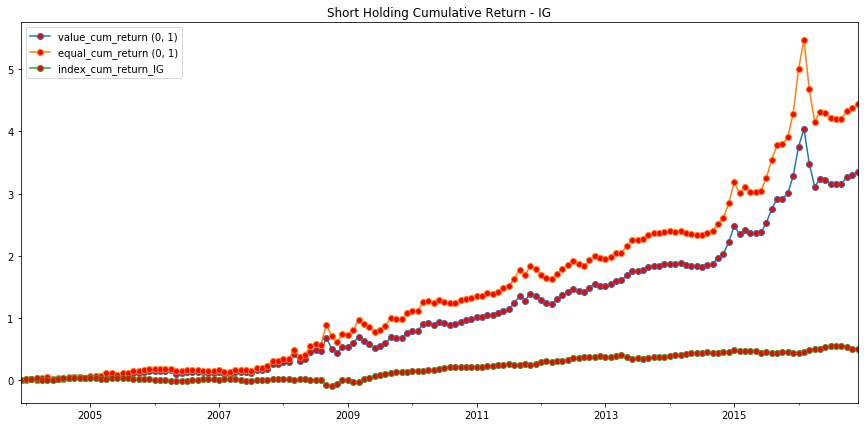

In [17]:
title_txt = 'Short Holding Cumulative Return - IG'
risk_weight_index_short_IG.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=1, marker='o', markerfacecolor='red')

In [18]:
weight_test_long_IG = weight_type_test(perf_test_weight_long_holing_IG)
risk_weight_test_long_IG, risk_weight_index_long_IG = get_risk_indicator(perf_test_weight_long_holing_IG, data_universe)

In [19]:
weight_test_long_IG.round(5)

,"value_return (0, 6)","equal_return (0, 6)",Result1,Result2
Correlation,0.99119,0.99119,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.74376,0.74376,Equal,Equal


In [20]:
risk_weight_test_long_IG

,"value_return (0, 6)","equal_return (0, 6)"
Excess annual return,0.0167389,0.0259613
Excess cumulative return,0.242577,0.398396
Excess mean return,0.00138432,0.00213812
Volatility,0.0204251,0.0228264
Annualized Sharpe ratio,0.0779989,0.104978
Alpha,0.00271421,0.00376085
Beta,-0.412407,-0.501978
Skewness,-0.0374267,0.607428
Kurtosis,7.75528,7.46468
MaxDD,-0.195034,-0.181327


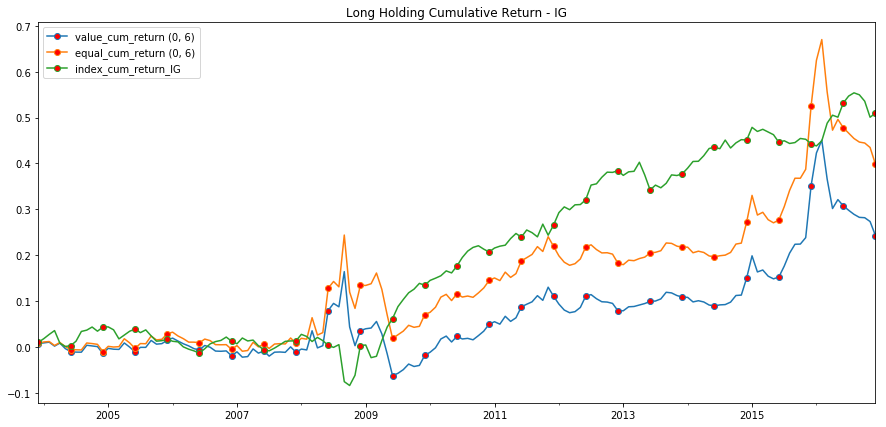

In [21]:
title_txt = 'Long Holding Cumulative Return - IG'
risk_weight_index_long_IG.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=6, marker='o', markerfacecolor='red')

# BBB universe

In [22]:
data_universe = 'BBB'

In [23]:
perf_test_weight_short_holing_BBB = performance_backtest(formation_date, data_universe, avg_range, holding_range_s, test_period, TMT)

In [24]:
perf_test_weight_long_holing_BBB = performance_backtest(formation_date, data_universe, avg_range, holding_range_l, test_period, TMT)

In [25]:
weight_test_short_BBB = weight_type_test(perf_test_weight_short_holing_BBB)
risk_weight_test_short_BBB, risk_weight_index_short_BBB = get_risk_indicator(perf_test_weight_short_holing_BBB, data_universe)

In [26]:
weight_test_short_BBB.round(5)

,"value_return (0, 1)","equal_return (0, 1)",Result1,Result2
Correlation,0.98513,0.98513,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.73688,0.73688,Equal,Equal


In [27]:
risk_weight_test_short_BBB

,"value_return (0, 1)","equal_return (0, 1)"
Excess annual return,0.131293,0.150301
Excess cumulative return,4.02273,5.24624
Excess mean return,0.0103331,0.011737
Volatility,0.0384181,0.0415569
Annualized Sharpe ratio,0.288498,0.303276
Alpha,0.0101221,0.0119912
Beta,0.257287,0.163772
Skewness,-0.742626,-0.26534
Kurtosis,9.16503,6.97855
MaxDD,-0.225645,-0.239756


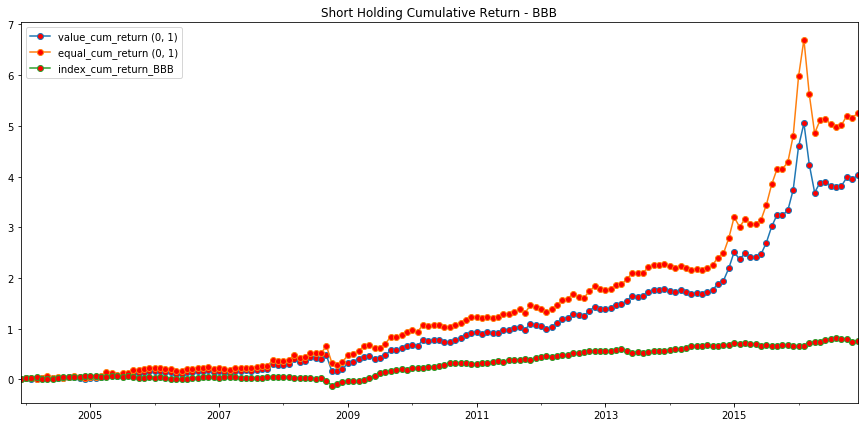

In [28]:
title_txt = 'Short Holding Cumulative Return - BBB'
risk_weight_index_short_BBB.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=1, marker='o', markerfacecolor='red')

In [29]:
weight_test_long_BBB = weight_type_test(perf_test_weight_long_holing_BBB)
risk_weight_test_long_BBB, risk_weight_index_long_BBB = get_risk_indicator(perf_test_weight_long_holing_BBB, data_universe)

In [30]:
weight_test_long_BBB.round(5)

,"value_return (0, 6)","equal_return (0, 6)",Result1,Result2
Correlation,0.99125,0.99125,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.78072,0.78072,Equal,Equal


In [31]:
risk_weight_test_long_BBB

,"value_return (0, 6)","equal_return (0, 6)"
Excess annual return,0.0155834,0.0241653
Excess cumulative return,0.224229,0.366706
Excess mean return,0.00128944,0.00199181
Volatility,0.0227283,0.0246678
Annualized Sharpe ratio,0.0680119,0.0929298
Alpha,0.0015789,0.00243962
Beta,-0.00885949,-0.0394031
Skewness,0.558247,0.783902
Kurtosis,7.48894,7.7181
MaxDD,-0.208944,-0.227378


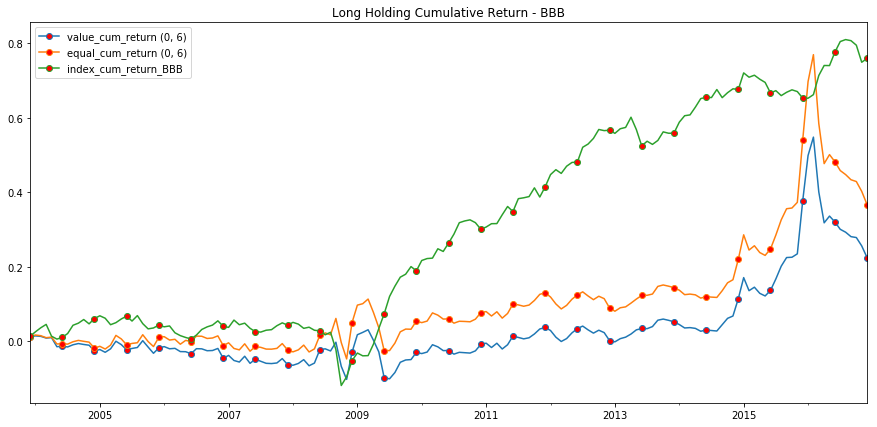

In [32]:
title_txt = 'Long Holding Cumulative Return - BBB'
risk_weight_index_long_BBB.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=6, marker='o', markerfacecolor='red')

# HY universe

In [33]:
data_universe = 'HY'

In [34]:
perf_test_weight_short_holing_HY = performance_backtest(formation_date, data_universe, avg_range, holding_range_s, test_period, TMT)
perf_test_weight_long_holing_HY = performance_backtest(formation_date, data_universe, avg_range, holding_range_l, test_period, TMT)

In [35]:
weight_test_short_HY = weight_type_test(perf_test_weight_short_holing_HY)
risk_weight_test_short_HY, risk_weight_index_short_HY = get_risk_indicator(perf_test_weight_short_holing_HY, data_universe)

In [36]:
weight_test_short_HY.round(5)

,"value_return (0, 1)","equal_return (0, 1)",Result1,Result2
Correlation,0.93819,0.93819,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00048,Yes,Yes
T-test (mean),0.52296,0.52296,Equal,Equal


In [37]:
risk_weight_test_short_HY

,"value_return (0, 1)","equal_return (0, 1)"
Excess annual return,0.428584,0.547169
Excess cumulative return,105.337,300.847
Excess mean return,0.0301698,0.0370384
Volatility,0.0955959,0.0963252
Annualized Sharpe ratio,0.358595,0.427895
Alpha,0.0385062,0.0457293
Beta,-0.742164,-0.792412
Skewness,1.67676,1.41914
Kurtosis,7.35871,4.97336
MaxDD,-0.284184,-0.234126


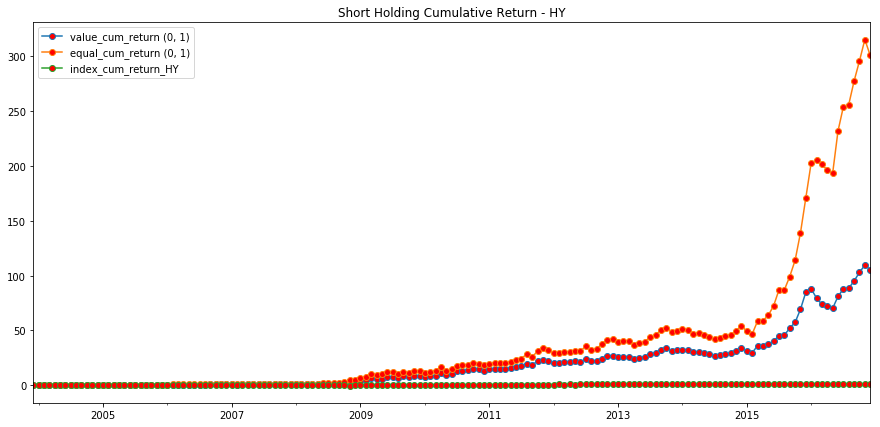

In [38]:
title_txt = 'Short Holding Cumulative Return - HY'
risk_weight_index_short_HY.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=1, marker='o', markerfacecolor='red')

In [39]:
weight_test_long_HY = weight_type_test(perf_test_weight_long_holing_HY)
risk_weight_test_long_HY, risk_weight_index_long_HY = get_risk_indicator(perf_test_weight_long_holing_HY, data_universe)

In [40]:
weight_test_long_HY.round(5)

,"value_return (0, 6)","equal_return (0, 6)",Result1,Result2
Correlation,0.91651,0.91651,Positive correlation,Positive correlation
Shapiro (Gaussian),0.00000,0.00000,No,No
Adfuller (stationary),0.00000,0.00000,Yes,Yes
T-test (mean),0.45957,0.45957,Equal,Equal


In [41]:
risk_weight_test_long_HY

,"value_return (0, 6)","equal_return (0, 6)"
Excess annual return,0.0206546,0.077629
Excess cumulative return,0.306665,1.65954
Excess mean return,0.00170513,0.00624972
Volatility,0.0570563,0.0657217
Annualized Sharpe ratio,0.0591574,0.129864
Alpha,0.00708051,0.0119479
Beta,-0.650698,-0.599372
Skewness,-0.421814,-0.882946
Kurtosis,5.19541,8.03858
MaxDD,-0.476772,-0.517575


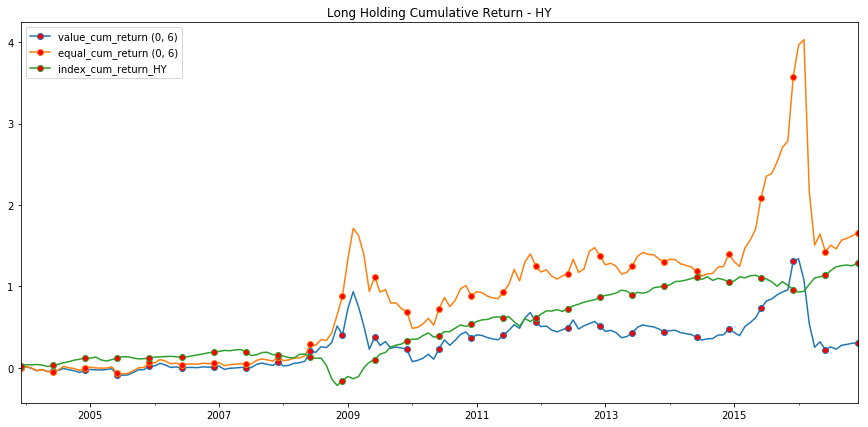

In [42]:
title_txt = 'Long Holding Cumulative Return - HY'
risk_weight_index_long_HY.iloc[:, [2,3,6]].plot(figsize=(15,7), title = title_txt, 
                           style='.-', markevery=6, marker='o', markerfacecolor='red')